In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import time
import itertools
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [8]:
# Caricamento dataset
data_dir = "/Users/alberto/Desktop/parking/clf-data"   # cartella che contiene empty/ e not_empty/

# Carichiamo SOLO per fare analisi
raw_dataset = datasets.ImageFolder(data_dir)
raw_dataset.classes, raw_dataset.class_to_idx

(['empty', 'not_empty'], {'empty': 0, 'not_empty': 1})

In [9]:
# Conteggio immagini

from collections import Counter

labels = [label for _, label in raw_dataset]
Counter(labels)


Counter({0: 3045, 1: 3045})

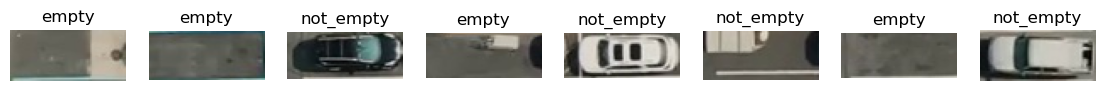

In [11]:
# Visualizzare alcune immagini random di entrmabe le classi
import random

def show_samples_balanced(dataset, n=6):
    plt.figure(figsize=(14, 5))
    indices = random.sample(range(len(dataset)), n)
    
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(dataset.classes[label])
        plt.axis("off")

show_samples_balanced(raw_dataset, n=8)




In [12]:
# Check dimensione immagini in termini di Pixel
from PIL import Image
import os

sample_path = os.path.join(data_dir, raw_dataset.samples[0][0])
img = Image.open(sample_path)
img.size


(69, 29)

In [16]:
# We resize the images in order to apply ResNet18
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# PyTorch applica il transform solo quando viene caricato un batch dal DataLoader, quindi non stiamo normalizando qui

# Full dataset after transform
full_dataset = datasets.ImageFolder(data_dir, transform)

class_names = full_dataset.classes
class_names

['empty', 'not_empty']

In [17]:
# Splitting in Training/Test/Validation set 
from torch.utils.data import random_split

total = len(full_dataset)

train_size = int(0.70 * total)
val_size   = int(0.15 * total)
test_size  = total - train_size - val_size  # per arrivare a 100%

train_set, val_set, test_set = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # per riproducibilità
)

len(train_set), len(val_set), len(test_set)


(4263, 913, 914)

In [18]:
# DataLoader 
from torch.utils.data import DataLoader

batch_size = 64 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False)


Shuffle è applicato solo al training perché l’ottimizzazione stocastica richiede campioni in ordine casuale per garantire una buona convergenza e ridurre le correlazioni tra batch. Validation e test non devono essere shufflati perché servono a misurare le prestazioni in modo stabile, deterministico e riproducibile.

We selected batch size = 64 because it represents the optimal balance between training stability, generalization, and hardware constraints when fine-tuning a pre-trained model like ResNet18 on a medium-sized dataset.

1. Optimal gradient estimation for transfer learning
In transfer learning, large batch sizes (e.g., 256) tend to produce overly smooth gradients that can hinder adaptation to the new domain.
Conversely, very small batches (e.g., 8 or 16) introduce excessive gradient noise.
Empirical and theoretical work on fine-tuning pre-trained networks shows that moderate batch sizes (32–64) provide the best trade-off between stability and generalization.

2. Efficient use of available GPU memory
With 8 GB of VRAM, ResNet18 allows batch sizes up to 64–128, but 64 ensures:
safe and consistent memory usage,
avoidance of out-of-memory errors,
fast training throughput.
Thus, batch 64 efficiently utilizes the hardware without risking memory saturation.

3. Consistency with common practice for ResNet fine-tuning
In applied computer vision tasks similar to parking occupancy classification, batch sizes between 32 and 64 are most commonly adopted.
Batch 64 aligns with these well-established configurations, balancing convergence speed and stability.

In [ ]:
def init_weights_kaiming(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

model = models.resnet18(weights=None)  # NESSUN pre-trained
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classi

model.apply(init_weights_kaiming)